In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import pandas as pd
from MatrixVectorizer import *
import torch
import random
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import optuna
import seaborn as sns

In [2]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Check for CUDA (GPU support) and set device accordingly
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # For multi-GPU setups
    # Additional settings for ensuring reproducibility on CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

CUDA is available. Using GPU.
cuda


# Import Data

In [3]:
# A_LR_train = pd.read_csv("../data/lr_train.csv")
# A_HR_train = pd.read_csv("../data/hr_train.csv")
# A_LR_test = pd.read_csv("../data/lr_test.csv")

In [4]:
LR_size = 160
HR_size = 268

In [5]:
# from sklearn.decomposition import PCA
# from sklearn.mixture import GaussianMixture

# A_HR_train = pd.read_csv("../data/hr_train.csv")

# pca = PCA(n_components=0.99, whiten=False)
# A_HR_train_pca = pca.fit_transform(A_HR_train)
# print(A_HR_train_pca.shape)

# gm = GaussianMixture(n_components=5, random_state=random_seed)
# A_HR_train_label = gm.fit_predict(A_HR_train_pca)
# unique, counts = np.unique(A_HR_train_label, return_counts=True)
# print(np.asarray((unique, counts)).T)

# X = np.load('A_LR_train_matrix.npy')
# y = np.load('A_HR_train_matrix.npy')

# n_sample = X.shape[0]
# X_train, X_val, y_train, y_val = train_test_split(
#     X.reshape(n_sample, -1), 
#     y.reshape(n_sample, -1), 
#     test_size=0.20, 
#     random_state=random_seed,
#     stratify=A_HR_train_label
# )

# X_train = X_train.reshape(-1, LR_size, LR_size)
# X_val = X_val.reshape(-1, LR_size, LR_size)
# y_train = y_train.reshape(-1, HR_size, HR_size)
# y_val = y_val.reshape(-1, HR_size, HR_size)

# print("Train size:", len(X_train))
# print("Val size:", len(X_val))

In [6]:
# def antivectorize_df(adj_mtx_df, size):
    
#     num_subject = adj_mtx_df.shape[0]
#     adj_mtx = np.zeros((num_subject, size, size)) #torch.zeros((num_subject, LR_size, LR_size))
#     for i in range(num_subject):
#         adj_mtx[i] = MatrixVectorizer.anti_vectorize(adj_mtx_df.iloc[i], size) # torch.from_numpy(MatrixVectorizer.anti_vectorize(A_LR_train.iloc[i], LR_size))
#     return adj_mtx

# np.save('A_LR_train_matrix.npy', antivectorize_df(A_LR_train, LR_size))
# np.save('A_HR_train_matrix.npy', antivectorize_df(A_HR_train, HR_size))
# np.save('A_LR_test_matrix.npy', antivectorize_df(A_LR_test, LR_size))

In [7]:
A_LR_train_matrix = np.load('A_LR_train_matrix.npy')
A_HR_train_matrix = np.load('A_HR_train_matrix.npy')
A_LR_test_matrix = np.load("A_LR_test_matrix.npy")

print(A_LR_train_matrix.shape)
print(A_HR_train_matrix.shape)
print(A_LR_test_matrix.shape)

(167, 160, 160)
(167, 268, 268)
(112, 160, 160)


# Parameters

In [8]:
import torch
import numpy as np
import torch.optim as optim
from sklearn.model_selection import KFold
from preprocessing import *
from model import *
from train import *
import argparse



epochs = 200


parser = argparse.ArgumentParser(description='GSR-Net')
parser.add_argument('--epochs', type=int, default=epochs, metavar='no_epochs',
                help='number of episode to train ')
parser.add_argument('--lr', type=float, default=0.0001, metavar='lr',
                help='learning rate (default: 0.0001 using Adam Optimizer)')
parser.add_argument('--splits', type=int, default=3, metavar='n_splits',
                help='no of cross validation folds')
parser.add_argument('--lmbda', type=int, default=16, metavar='L',
                help='self-reconstruction error hyperparameter')
parser.add_argument('--lr_dim', type=int, default=LR_size, metavar='N',
                help='adjacency matrix input dimensions')
parser.add_argument('--hr_dim', type=int, default=HR_size, metavar='N',
                help='super-resolved adjacency matrix output dimensions')
parser.add_argument('--hidden_dim', type=int, default=268, metavar='N',
                help='hidden GraphConvolutional layer dimensions')
parser.add_argument('--padding', type=int, default=26, metavar='padding',
                help='dimensions of padding')
parser.add_argument('--embedding_size', type=int, default=32, metavar='embedding_size',
                help='node embedding size')
parser.add_argument('--early_stop_patient', type=int, default=5, metavar='early_stop_patient',
                help='early_stop_patience')

parser.add_argument('--p_perturbe', type=float, default=0.5, metavar='p_perturbe',
                help='p_perturbe')
parser.add_argument('--p_drop_node', type=float, default=0.03, metavar='p_drop_node',
                help='p_drop_node')
parser.add_argument('--p_drop_edges', type=float, default=0.1, metavar='p_drop_edges',
                help='p_drop_edges')
parser.add_argument('--mean_dense', type=float, default=0., metavar='mean',
                        help='mean of the normal distribution in Dense Layer')
parser.add_argument('--std_dense', type=float, default=0.01, metavar='std',
                    help='standard deviation of the normal distribution in Dense Layer')
parser.add_argument('--mean_gaussian', type=float, default=0., metavar='mean',
                    help='mean of the normal distribution in Gaussian Noise Layer')
parser.add_argument('--std_gaussian', type=float, default=0.1, metavar='std',
                    help='standard deviation of the normal distribution in Gaussian Noise Layer')


# Create an empty Namespace to hold the default arguments
args = parser.parse_args([]) 
print(args)

Namespace(epochs=200, lr=0.0001, splits=3, lmbda=16, lr_dim=160, hr_dim=268, hidden_dim=268, padding=26, embedding_size=32, early_stop_patient=5, p_perturbe=0.5, p_drop_node=0.03, p_drop_edges=0.1, mean_dense=0.0, std_dense=0.01, mean_gaussian=0.0, std_gaussian=0.1)


In [9]:
# SIMULATING THE DATA: EDIT TO ENTER YOUR OWN DATA
X = A_LR_train_matrix #np.random.normal(0, 0.5, (167, 160, 160))
Y = A_HR_train_matrix #np.random.normal(0, 0.5, (167, 288, 288))
print(X.shape)
print(Y.shape)

(167, 160, 160)
(167, 268, 268)


In [10]:
device = get_device()
print(device)

cuda


In [11]:
def compute_degree_matrix_normalization_batch_numpy(adjacency_batch):
    """
    Optimizes the degree matrix normalization for a batch of adjacency matrices using NumPy.
    Computes the normalized adjacency matrix D^-1 * A for each graph in the batch.
    
    Parameters:
    - adjacency_batch: A NumPy array of shape (batch_size, num_nodes, num_nodes) representing
                       a batch of adjacency matrices.

    Returns:
    - A NumPy array of normalized adjacency matrices.
    """
    epsilon = 1e-6  # Small constant to avoid division by zero
    # Calculate the degree for each node in the batch
    d = adjacency_batch.sum(axis=2) + epsilon
    
    # Compute the inverse degree matrix D^-1 for the batch
    D_inv = np.reciprocal(d)[:, :, np.newaxis] * np.eye(adjacency_batch.shape[1])[np.newaxis, :, :]
    
    # Normalize the adjacency matrix using batch matrix multiplication
    normalized_adjacency_batch = np.matmul(D_inv, adjacency_batch)
    
    return normalized_adjacency_batch
X = compute_degree_matrix_normalization_batch_numpy(X)
A_LR_test_matrix = compute_degree_matrix_normalization_batch_numpy(A_LR_test_matrix)
print(X.shape)

(167, 160, 160)


# Hyperparameter Tuning

In [12]:
A_HR_train = pd.read_csv("../data/hr_train.csv")

pca = PCA(n_components=0.99, whiten=False)
A_HR_train_pca = pca.fit_transform(A_HR_train)
print(A_HR_train_pca.shape)

gm = GaussianMixture(n_components=5, random_state=random_seed)
A_HR_train_label = gm.fit_predict(A_HR_train_pca)
unique, counts = np.unique(A_HR_train_label, return_counts=True)
print(np.asarray((unique, counts)).T)

(167, 161)
[[ 0 13]
 [ 1 41]
 [ 2 14]
 [ 3 48]
 [ 4 51]]


In [12]:
import gc

best_mae = 1000
best_params = None
best_model = None

def hyperparameter_search(n_trials=40):
    def objective(trial):
        global best_mae
        global best_params
        global best_model
        ks = [0.9, 0.7, 0.6, 0.5]
        num_epochs = 200
        lr = trial.suggest_float('lr', 9e-5, 3e-4, log=True)
        lmbda = trial.suggest_int('lmbda', 12, 52, step=4)
        
        hidden_dim = 268
        stop_gan_mae = 0.135
        patience = 5
        ks = trial.suggest_categorical("ks", [[0.9, 0.7, 0.6, 0.5], [0.9, 0.7, 0.5], [0.8, 0.5], [0.9, 0.8, 0.7, 0.6, 0.5], [0.5]])
        # dropout_rate = trial.suggest_float('dropout_rate', 0.05, 0.3, step=0.05)
        # p_perturbe = trial.suggest_float('p_perturbe', 0, 0.7, step=0.05)
        # p_drop_node = trial.suggest_float('p_drop_node', 0.01, 0.1, step=0.005)
        # p_drop_edges = trial.suggest_float('p_drop_edges', 0.03, 0.18, step=0.005)

        args.epochs = num_epochs
        args.lr = lr
        args.lmbda = lmbda
        args.hidden_dim = hidden_dim
        args.early_stop_patient = patience
        # args.dropout_rate = dropout_rate
        # args.p_perturbe = p_perturbe
        # args.p_drop_node = p_drop_node
        # args.p_drop_edges = p_drop_edges

        params = {
                "lr": lr,
                "lmbda": lmbda,
                "hidden_dim": hidden_dim,
                "patience": patience,
                # "dropout_rate": dropout_rate,
                # "p_perturbe": p_perturbe,
                # "p_drop_node": p_drop_node,
                # "p_drop_edges": p_drop_edges,
                "ks": ks,
            }
        print(f"Trial {trial.number}: {params}")

        n_sample = X.shape[0]
        X_train, X_val, y_train, y_val = train_test_split(
            X.reshape(n_sample, -1), 
            Y.reshape(n_sample, -1), 
            test_size=0.10, 
            random_state=random_seed,
            stratify=A_HR_train_label
        )
        
        X_train = X_train.reshape(-1, LR_size, LR_size)
        X_val = X_val.reshape(-1, LR_size, LR_size)
        y_train = y_train.reshape(-1, HR_size, HR_size)
        y_val = y_val.reshape(-1, HR_size, HR_size)

        modelG = GSRNet(ks, args).to(device)
        optimizerG = torch.optim.Adam(modelG.parameters(), lr=args.lr)

        modelD = Discriminator(args).to(device)
        optimizerD = optim.Adam(modelD.parameters(), lr=args.lr)
        
        return_model = train_gan(
            modelG, 
            optimizerG, 
            modelD, 
            optimizerD, 
            X_train, 
            y_train, 
            args, 
            X_val, 
            y_val,
        )
        test_mae = test(return_model, X_val, y_val, args)
        mean_mae = test_mae
        if mean_mae < best_mae:
            best_mae = mean_mae
            best_params = params
            best_model = return_model
            print(f"New best MAE: {test_mae} with params: {best_params}")

        return mean_mae
    
    study = optuna.create_study(direction='minimize', study_name='GSR_hyperparameter_search', sampler=optuna.samplers.TPESampler())
    study.optimize(objective, n_trials=n_trials)
    return study.best_params

# best_params = hyperparameter_search(40)
# print(best_params)

In [13]:
ks = [0.9, 0.7, 0.6, 0.5]
gan_params = {
    'lr': 0.00010436239086997339, 
    'lmbda': 24, 
    'hidden_dim': 268, 
    'patience': 5, 
    'dropout_rate': 0.15000000000000002, 
    'p_perturbe': 0.5, 
    'p_drop_node': 0.05, 
    'p_drop_edges': 0.11
}

vars(args).update(gan_params)
print(args)

Namespace(epochs=200, lr=0.00010436239086997339, splits=3, lmbda=24, lr_dim=160, hr_dim=268, hidden_dim=268, padding=26, embedding_size=32, early_stop_patient=5, p_perturbe=0.5, p_drop_node=0.05, p_drop_edges=0.11, mean_dense=0.0, std_dense=0.01, mean_gaussian=0.0, std_gaussian=0.1, patience=5, dropout_rate=0.15000000000000002)


# K-Fold Cross Validation

In [15]:
cv = KFold(n_splits=args.splits, random_state=random_seed, shuffle=True)

ks = [0.9, 0.7, 0.6, 0.5]
stop_gan_mae = 0.135

best_model_fold_list = []
data_fold_list = []
i = 1
for train_index, test_index in cv.split(X):

    print(f"----- Fold {i} -----")
    subjects_adj, test_adj, subjects_ground_truth, test_ground_truth = X[
        train_index], X[test_index], Y[train_index], Y[test_index]
    data_fold_list.append((subjects_adj, test_adj, subjects_ground_truth, test_ground_truth))

    netG = GSRNet(ks, args).to(device)
    optimizerG = optim.Adam(netG.parameters(), lr=args.lr)

    netD = Discriminator(args).to(device)
    optimizerD = optim.Adam(netD.parameters(), lr=args.lr)

    #GAN model
    return_model = train_gan(
        netG, 
        optimizerG, 
        netD,
        optimizerD,
        subjects_adj, 
        subjects_ground_truth, 
        args, 
        test_adj=test_adj, 
        test_ground_truth=test_ground_truth,
    )

    test_mae = test(return_model, test_adj, test_ground_truth, args)
    train_mae = test(return_model, subjects_adj, subjects_ground_truth, args)
    print(f"Train MAE: {train_mae:.6f}, Val MAE: {test_mae:.6f}")
    best_model_fold_list.append(return_model)

    i += 1

----- Fold 1 -----


Epoch Progress:   0%|          | 0/200 [00:00<?, ?epoch/s]

Val Error: 0.128117
Train MAE: 0.129065, Val MAE: 0.128117
----- Fold 2 -----


Epoch Progress:   0%|          | 0/200 [00:00<?, ?epoch/s]

Val Error: 0.137824
Train MAE: 0.127409, Val MAE: 0.137824
----- Fold 3 -----


Epoch Progress:   0%|          | 0/200 [00:00<?, ?epoch/s]

Val Error: 0.134425
Train MAE: 0.131564, Val MAE: 0.134425


In [14]:
from MatrixVectorizer import MatrixVectorizer

from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon
import torch
import networkx as nx

def evaluate(pred_matrices, gt_matrices, cal_graph=False):

    # pred_matrices = pred_matrices.cpu().detach().numpy()
    # gt_matrices = gt_matrices.cpu().detach().numpy()

    num_test_samples = gt_matrices.shape[0]

    # Initialize lists to store MAEs for each centrality measure
    mae_bc = []
    mae_ec = []
    mae_pc = []
    
    pred_1d = []
    gt_1d = []

    # Iterate over each test sample
    for i in tqdm(range(num_test_samples)):

        pred_1d.append(MatrixVectorizer.vectorize(pred_matrices[i]))
        gt_1d.append(MatrixVectorizer.vectorize(gt_matrices[i]))

        if cal_graph:
            # Convert adjacency matrices to NetworkX graphs
            pred_graph = nx.from_numpy_array(pred_matrices[i])
            gt_graph = nx.from_numpy_array(gt_matrices[i])

            # Compute centrality measures
            pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
            pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight")
            pred_pc = nx.pagerank(pred_graph, weight="weight")

            gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
            gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight")
            gt_pc = nx.pagerank(gt_graph, weight="weight")

            # Convert centrality dictionaries to lists
            pred_bc_values = list(pred_bc.values())
            pred_ec_values = list(pred_ec.values())
            pred_pc_values = list(pred_pc.values())

            gt_bc_values = list(gt_bc.values())
            gt_ec_values = list(gt_ec.values())
            gt_pc_values = list(gt_pc.values())

            # Compute MAEs
            mae_bc.append(mean_absolute_error(pred_bc_values, gt_bc_values))
            mae_ec.append(mean_absolute_error(pred_ec_values, gt_ec_values))
            mae_pc.append(mean_absolute_error(pred_pc_values, gt_pc_values))

    if cal_graph:
        # Compute average MAEs
        avg_mae_bc = sum(mae_bc) / len(mae_bc)
        avg_mae_ec = sum(mae_ec) / len(mae_ec)
        avg_mae_pc = sum(mae_pc) / len(mae_pc)

    # vectorize and flatten
    pred_1d = np.concatenate(pred_1d, axis=0).flatten()
    gt_1d = np.concatenate(gt_1d, axis=0).flatten()

    mae = mean_absolute_error(pred_1d, gt_1d)
    pcc = pearsonr(pred_1d, gt_1d)[0]
    js_dis = jensenshannon(pred_1d, gt_1d)

    print("MAE: ", mae)
    print("PCC: ", pcc)
    print("Jensen-Shannon Distance: ", js_dis)
    if cal_graph:
        print("Average MAE betweenness centrality:", avg_mae_bc)
        print("Average MAE eigenvector centrality:", avg_mae_ec)
        print("Average MAE PageRank centrality:", avg_mae_pc)

    if cal_graph:

        res = {
            "MAE": mae,
            "PCC": pcc,
            "JSD": js_dis,
            "MAE_(BC)": avg_mae_bc,
            "MAE_(EC)": avg_mae_ec,
            "MAE_(PC)": avg_mae_pc
        }
    else:
        res = {
            "MAE": mae,
            "PCC": pcc,
            "JSD": js_dis,
            # "MAE_(BC)": avg_mae_bc,
            # "MAE_(EC)": avg_mae_ec,
            # "MAE_(PC)": avg_mae_pc
        }

    return res
  
  
def plot_metrics_fold(res_list):
    df = pd.DataFrame(res_list)
    df = df.rename(columns={"mae": "MAE", "pcc": "PCC", "js_dis": "JSD", "avg_mae_bc": "MAE_(BC)", "avg_mae_ec": "MAE_(EC)", "avg_mae_pc": "MAE_(PC)"})
    df.index = df.index.set_names(['Fold'])
    df.loc['mean'] = df.mean()
    avg_data = df.iloc[-1, :]
    df.loc['std'] = df.std()
    errors = df.iloc[-1, :].tolist()
    df = df.reset_index()
    df = df.iloc[:-2, :]
    df_long = df.melt(id_vars='Fold', var_name='Metric', value_name='Value')
    palette = sns.color_palette("muted", n_colors=len(df_long['Metric'].unique()))
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    for fold in range(3):   
        i = fold // 2
        j = fold % 2
        sns.barplot(x='Metric', y='Value', data=df_long[df_long['Fold'] == fold], ax=axs[i, j], palette=palette, hue='Metric')
        axs[i, j].set_title(f"Fold: {fold+1}")


    bars = sns.barplot(x=avg_data.index, y=avg_data.values, ax=axs[1, 1], palette=palette, capsize=5)

    for i, bar in enumerate(bars.patches):
        # Calculate the x-position of the error bar
        x_pos = bar.get_x() + bar.get_width() / 2

        # Add error bar for this metric
        axs[1, 1].errorbar(x_pos, avg_data.values[i], yerr=errors[i], fmt='none', color='black', capsize=5)
    
    axs[1, 1].set_title("Avg. Across Folds")
    plt.show()

In [23]:
CAL_GRAPH = False

res_list = []

for i in range(args.splits):
    _, test_adjs, _, gt_matrices = data_fold_list[i]
    model = best_model_fold_list[i]
    model.eval()
    pred_matrices = np.zeros(gt_matrices.shape)
    with torch.no_grad():
        for j, test_adj in enumerate(test_adjs):
            pred = model(torch.from_numpy(test_adj))[0]
            pred = torch.clamp(pred, min=0.0, max=1.0)
            pred = pred.cpu()
            pred_matrices[j] = pred
    res_list.append(evaluate(pred_matrices, gt_matrices, cal_graph=CAL_GRAPH))

pd.DataFrame(res_list)

  0%|          | 0/56 [00:00<?, ?it/s]

MAE:  0.12811324669047927
PCC:  0.6693563951327818
Jensen-Shannon Distance:  0.2768801859878052
Average MAE betweenness centrality: 0.02082866872266793
Average MAE eigenvector centrality: 0.013126641105436007
Average MAE PageRank centrality: 0.0005528267509704363


  0%|          | 0/56 [00:00<?, ?it/s]

MAE:  0.13781712295279994
PCC:  0.6351482000890718
Jensen-Shannon Distance:  0.28895718016261684
Average MAE betweenness centrality: 0.020615481379714834
Average MAE eigenvector centrality: 0.013825333952471697
Average MAE PageRank centrality: 0.0005702821231801657


  0%|          | 0/55 [00:00<?, ?it/s]

MAE:  0.13442560779436277
PCC:  0.6467274374201493
Jensen-Shannon Distance:  0.28334452234454505
Average MAE betweenness centrality: 0.02049117388932212
Average MAE eigenvector centrality: 0.01325936322897272
Average MAE PageRank centrality: 0.0005672289388375054


,MAE,PCC,JSD,MAE_(BC),MAE_(EC),MAE_(PC)
0,0.128113,0.669356,0.276880,0.020829,0.013127,0.000553
1,0.137817,0.635148,0.288957,0.020615,0.013825,0.000570
2,0.134426,0.646727,0.283345,0.020491,0.013259,0.000567


/tmp/ipykernel_2145723/41024253.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=avg_data.index, y=avg_data.values, ax=axs[1, 1], palette=palette, capsize=5)


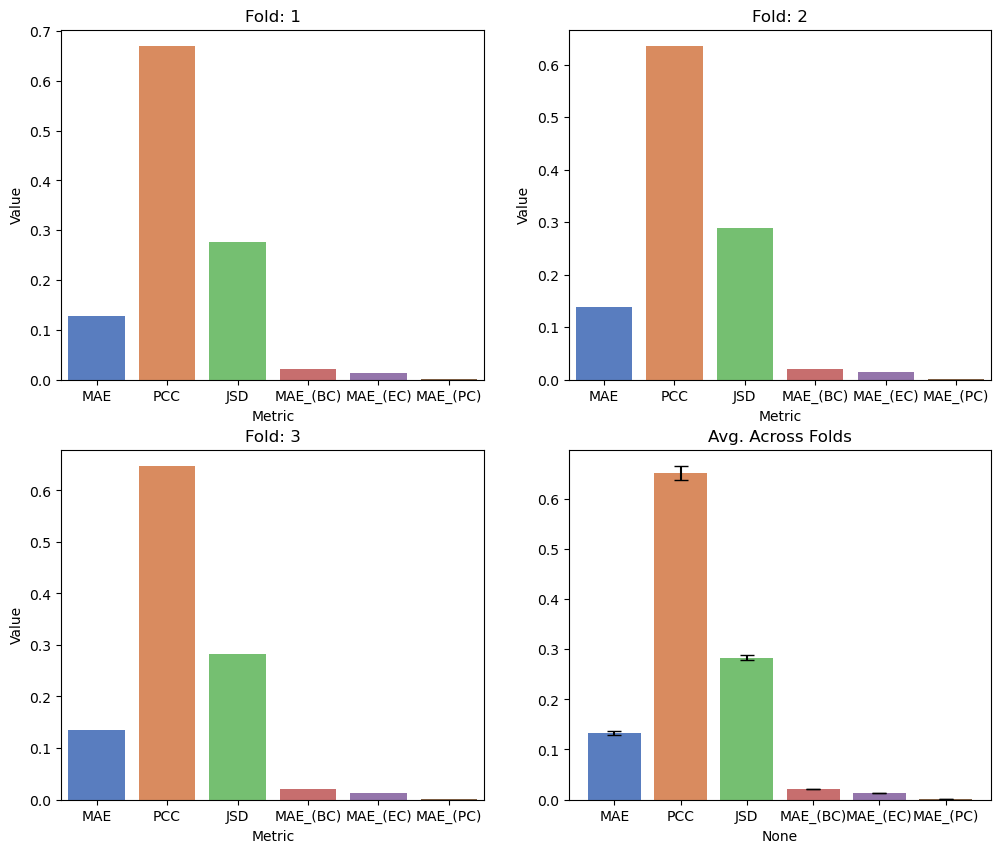

In [28]:
plot_metrics_fold(res_list)

In [29]:
for i in range(args.splits):
    _, test_adjs, _, gt_matrices = data_fold_list[i]
    model = best_model_fold_list[i]
    model.eval()

    output_pred_list = []
    with torch.no_grad():
        for j, test_adj in tqdm(enumerate(test_adjs)):
            output_pred = model(torch.from_numpy(test_adj))[0].cpu()
            output_pred = MatrixVectorizer.vectorize(output_pred).tolist()
            output_pred_list.append(output_pred)

    output_pred_stack = np.stack(output_pred_list, axis=0)
    output_pred_1d = output_pred_stack.flatten()

    df = pd.DataFrame({
        "ID": [i+1 for i in range(len(output_pred_1d))],
        "Predicted": output_pred_1d.tolist()
    })

    df.to_csv("predictions_fold_"+str(i+1)+".csv", index=False)

# Final Model

In [15]:
A_HR_train = pd.read_csv("../data/hr_train.csv")

pca = PCA(n_components=0.99, whiten=False)
A_HR_train_pca = pca.fit_transform(A_HR_train)
print(A_HR_train_pca.shape)

gm = GaussianMixture(n_components=5, random_state=random_seed)
A_HR_train_label = gm.fit_predict(A_HR_train_pca)
unique, counts = np.unique(A_HR_train_label, return_counts=True)
print(np.asarray((unique, counts)).T)

X = np.load('A_LR_train_matrix.npy')
y = np.load('A_HR_train_matrix.npy')
X = compute_degree_matrix_normalization_batch_numpy(X)

n_sample = X.shape[0]
X_train, X_val, y_train, y_val = train_test_split(
    X.reshape(n_sample, -1), 
    y.reshape(n_sample, -1), 
    test_size=0.10, 
    random_state=random_seed,
    stratify=A_HR_train_label
)

X_train = X_train.reshape(-1, LR_size, LR_size)
X_val = X_val.reshape(-1, LR_size, LR_size)
y_train = y_train.reshape(-1, HR_size, HR_size)
y_val = y_val.reshape(-1, HR_size, HR_size)

print("Train size:", len(X_train))
print("Val size:", len(X_val))

netG = GSRNet(ks, args).to(device)
optimizerG = optim.Adam(netG.parameters(), lr=args.lr)
args.early_stop_patient = 5

netG = GSRNet(ks, args).to(device)
optimizerG = optim.Adam(netG.parameters(), lr=args.lr)

netD = Discriminator(args).to(device)
optimizerD = optim.Adam(netD.parameters(), lr=args.lr)

#GAN model
return_model = train_gan(
    netG, 
    optimizerG, 
    netD,
    optimizerD,
    X_train, 
    y_train, 
    args, 
    test_adj=X_val, 
    test_ground_truth=y_val,
)

(167, 161)
[[ 0 13]
 [ 1 41]
 [ 2 14]
 [ 3 48]
 [ 4 51]]
Train size: 150
Val size: 17


Epoch Progress:   0%|          | 0/200 [00:00<?, ?epoch/s]

Val Error: 0.126491


In [17]:
final_model = return_model

In [18]:
print(args)

Namespace(epochs=200, lr=0.00010436239086997339, splits=3, lmbda=24, lr_dim=160, hr_dim=268, hidden_dim=268, padding=26, embedding_size=32, early_stop_patient=5, p_perturbe=0.5, p_drop_node=0.05, p_drop_edges=0.11, mean_dense=0.0, std_dense=0.01, mean_gaussian=0.0, std_gaussian=0.1, patience=5, dropout_rate=0.15000000000000002)


In [22]:
final_model.eval()
pred_train_matrices = np.zeros(y_train.shape)
pred_val_matrices = np.zeros(y_val.shape)
with torch.no_grad():
    for j, test_adj in enumerate(X_train):
        pred = final_model(torch.from_numpy(test_adj))[0]
        pred = torch.clamp(pred, min=0.0, max=1.0)
        pred = pred.cpu()
        pred_train_matrices[j] = pred

    print("Train")
    evaluate(pred_train_matrices, y_train)

    for j, test_adj in enumerate(X_val):
        pred = final_model(torch.from_numpy(test_adj))[0]
        pred = torch.clamp(pred, min=0.0, max=1.0)
        pred = pred.cpu()
        pred_val_matrices[j] = pred

    print("Val")
    evaluate(pred_val_matrices, y_val)

Train


  0%|          | 0/150 [00:00<?, ?it/s]

MAE:  0.12712688708289258
PCC:  0.6867034327149864
Jensen-Shannon Distance:  0.27423371063752394
Val


  0%|          | 0/17 [00:00<?, ?it/s]

MAE:  0.12648181392510183
PCC:  0.6876599834470514
Jensen-Shannon Distance:  0.26513463784552477


In [ ]:
output_pred_list = []
final_model.eval()
with torch.no_grad():
    for i in tqdm(range(A_LR_test_matrix.shape[0])):
        output_pred = final_model(torch.Tensor(A_LR_test_matrix[i]))[0]
        output_pred = torch.clamp(output_pred, min=0.0, max=1.0)
        output_pred = output_pred.cpu()
        output_pred = MatrixVectorizer.vectorize(output_pred).tolist()
        output_pred_list.append(output_pred)

  0%|          | 0/112 [00:00<?, ?it/s]

In [ ]:
output_pred_stack = np.stack(output_pred_list, axis=0)
output_pred_1d = output_pred_stack.flatten()
assert output_pred_1d.shape == (4007136, )

In [ ]:
df = pd.DataFrame({
    "ID": [i+1 for i in range(len(output_pred_1d))],
    "Predicted": output_pred_1d.tolist()
})

df

In [ ]:
df.to_csv("gsr_gat_residual_ne_drop_GAT_leakyrelu_fold0_90_10_split_normalized_gmm5_all_leaky_GSR_relu_clamp.csv", index=False)